In [1]:
%load_ext autoreload
%autoreload 2
# %cd /p/mmcardiac/Jerry/code/CINE-DENSE-Translation
%cd /home/jx8fh/Projects/LaMoD
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from modules.data import check_dict

/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD


In [89]:
# USE GPU 0
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [107]:
test_fname = '/scratch/jx8fh/2024-11-10-cine-to-extract-motion-128.npy'
test_data = np.load(test_fname, allow_pickle=True).tolist()

In [108]:
check_dict(test_data[10])

mag                                                          (128, 128, 32)      
mask                                                         (128, 128, 32)      


In [95]:
import json
config_fname = 'configs/ours-LaMoD.json'
config = json.load(open(config_fname))

In [96]:
from models.LaMoD import LaMoD
network = LaMoD(config['networks'], device).to(device)

Skip connect: False
Loading pretrained model from checkpoints/ours_registration.pth
Unrecognized keyword argument: beta_schedule_overwrite = True
Unrecognized keyword argument: load_pretrained = True
Unrecognized keyword argument: pretrained_model_path = checkpoints/ours_latent_diffusion.pth
beta_schedule_method='linear'
Loading pretrained model from checkpoints/ours_latent_diffusion.pth


/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Overwriting beta schedule with linear schedule with scale 30
ignorekwargs: {'type': 'DiffusionDecoder', 'drouput': 0.3, 'load_pretrained': True, 'pretrained_model_path': 'checkpoints/ours_motion_regression.pth'}
Decoder tanh_out:  False
Decoder: give_pre_end=False, tanh_out=False, out_scaling_factor=1
Working with z of shape (1, 16, 16, 16) = 4096 dimensions.
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 64 in_channels
making attention of type 'vanilla' with 64 in_channels
making attention of type 'vanilla' with 64 in_channels
Loading pretrained model from checkpoints/ours_motion_regression.pth


In [109]:
from skimage.transform import resize
check_data_idx = 1
inference_mask = torch.from_numpy(
    resize(test_data[check_data_idx]['mask'][...,0] > 0.5, [48,48], anti_aliasing=False)
)

In [110]:
# check_data_idx = 1

# Prepare Pytorch tensor
inference_input_video      = torch.from_numpy(test_data[check_data_idx]['mask']).to(device).moveaxis(-1,0)[None]
# inference_input_video_ori_frame = test_data[check_data_idx]['ori_n_frames']
inference_input_video_ori_frame = test_data[check_data_idx]['mask'].shape[-1]
inference_output_dict = network.inference(
    inference_input_video, 
    ori_n_frames=[inference_input_video_ori_frame])[0]

# Extract prediction
inference_disp = inference_output_dict['LaMoD_disp'].detach().cpu()

In [111]:
test_data[check_data_idx]['mask'].shape

(128, 128, 32)

In [112]:
inference_disp.shape

torch.Size([1, 2, 31, 48, 48])

In [120]:
inference_mask.shape

torch.Size([48, 48])

In [122]:
# convert inference_mask from shape (H,W) to (1,2,n_frames, H, W)
# inference_mask_vol = inference_mask[None, None, None].repeat(1, 2, 30, 1, 1)
# inference_mask_vol.shape

torch.Size([1, 2, 30, 48, 48])

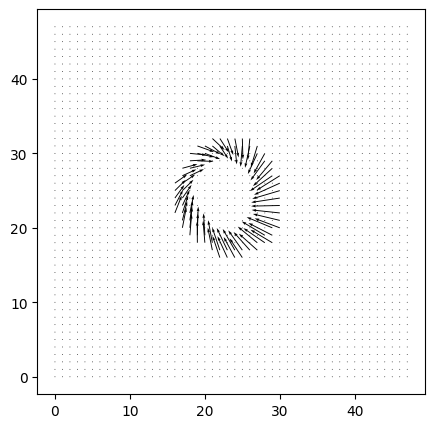

In [113]:
# Visualize 
check_frame_idx = 20
fig, axs = plt.subplots(1, 1, figsize=(5,5))
# Prediction
axs.quiver(
    inference_disp[0,0,check_frame_idx]*inference_mask,
    inference_disp[0,1,check_frame_idx]*inference_mask,
    units='xy',
    scale=1
)
# DENSE GT
# axs[1].quiver(
#     test_data[check_data_idx]['DENSE_disp'][0,check_frame_idx],
#     test_data[check_data_idx]['DENSE_disp'][1,check_frame_idx],
#     units='xy',
#     scale=1
# )

In [145]:

# make prediction for all data
import tqdm
predictions = []
for datum_idx, datum in enumerate(test_data):
    if datum is None:
        predictions.append(None)
        continue

    inference_input_video_ori_frame = datum['mask'].shape[-1]

    inference_mask = torch.from_numpy(resize(datum['mask'][...,0] > 0.5, [48,48], anti_aliasing=False))
    inference_mask_vol = inference_mask[None, None, None].repeat(1, 2, inference_input_video_ori_frame-1, 1, 1)

    # Prepare Pytorch tensor
    inference_input_video      = torch.from_numpy(datum['mask']).to(device).moveaxis(-1,0)[None]
    # inference_input_video_ori_frame = test_data[check_data_idx]['ori_n_frames']
    
    inference_output_dict = network.inference(
        inference_input_video, 
        ori_n_frames=[inference_input_video_ori_frame])[0]

    # Extract prediction
    inference_disp = inference_output_dict['LaMoD_disp'].detach().cpu() * inference_mask_vol

    predictions.append(inference_disp.numpy())

In [124]:
inference_output_dict['LaMoD_disp'].detach().cpu().shape

torch.Size([1, 2, 31, 48, 48])

In [125]:
inference_mask_vol.shape

torch.Size([1, 2, 32, 48, 48])

In [117]:
inference_disp.shape

torch.Size([1, 2, 31, 48, 48])

In [116]:
len(predictions)

363

(1, 2, 25, 48, 48)


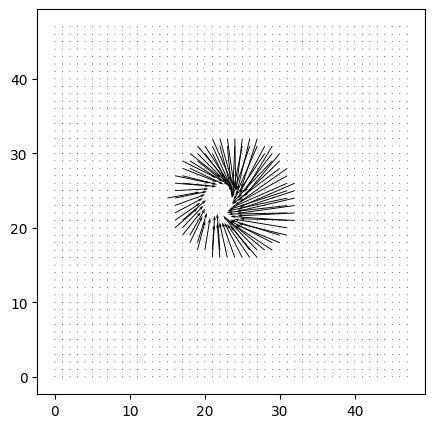

In [146]:
check_slice_idx = 20
check_frame_idx = 15
fig, axs = plt.subplots(1, 1, figsize=(5,5))
# Prediction
print(predictions[check_slice_idx].shape)
axs.quiver(
    predictions[check_slice_idx][0,0,check_frame_idx],
    predictions[check_slice_idx][0,1,check_frame_idx],
    units='xy',
    scale=1
)

In [136]:
len(predictions)

363

In [137]:
predictions[0]

In [156]:
type(predictions[0])

numpy.ndarray

In [ ]:
predictions

In [155]:
for p_idx in range(len(predictions)):
    if predictions[p_idx] is None:
        predictions[p_idx] = np.array([])

In [159]:
# save prediction
save_fname = Path('/scratch/jx8fh/2024-11-10-inference-LGE-cine.npy')
np.save(save_fname, np.array(predictions, dtype=object))

In [160]:
dd = np.load(save_fname, allow_pickle=True).tolist()

In [161]:
dd[1].shape

(1, 2, 31, 48, 48)

In [11]:
# load data
cine_LGE_data_fname = '/scratch/jx8fh/2024-09-04-LGE1K-all-matched-slices-363.npy'
cine_LGE_data = np.load(cine_LGE_data_fname, allow_pickle=True).tolist()

In [15]:
len(cine_LGE_data)

363

In [14]:
check_dict(cine_LGE_data[1]['cine'])

lv_endo                                                      (32,)               
lv_epi                                                       (32,)               
lv_papillary                                                 (32,)               
mv_annulus                                                   (32,)               
rv_endo                                                      (32,)               
rv_epi                                                       (32,)               
rv_papillary                                                 (32,)               
tv_annulus                                                   (32,)               
rv_insertion                                                 (32,)               
anterior_rv_insertion                                        (32,)               
ra_endo                                                      (32,)               
la_endo                                                      (32,)               
raw_image       

In [2]:
# load prediction to check
save_fname = Path('/scratch/jx8fh/2024-11-10-inference-LGE-cine.npy')
predictions = np.load(save_fname, allow_pickle=True).tolist()

In [18]:
# save to npy file
processed_cine_masks_fname = Path('/scratch/jx8fh/2024-11-10-cine-to-extract-motion-128.npy')
processed_cine_masks = np.load(processed_cine_masks_fname, allow_pickle=True).tolist()

In [28]:
len(processed_cine_masks)

363

In [20]:
check_dict(processed_cine_masks[1])

mag                                                          (128, 128, 32)      
mask                                                         (128, 128, 32)      


In [3]:
len(predictions)

363

In [9]:
predictions[0]

array([], dtype=float64)

In [8]:
predictions[1].shape

(1, 2, 31, 48, 48)

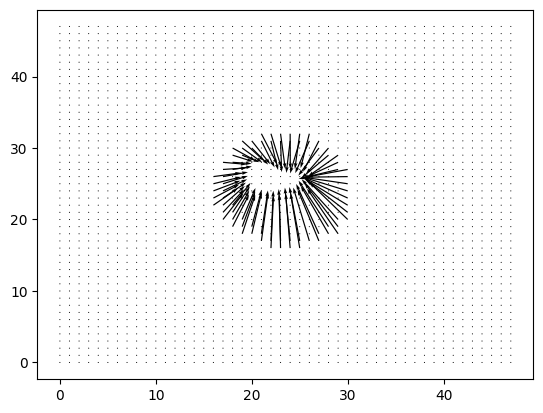

In [27]:
plt.quiver(
    predictions[1][0,0,10],
    predictions[1][0,1,10],
    units='xy',
    scale=1,
)

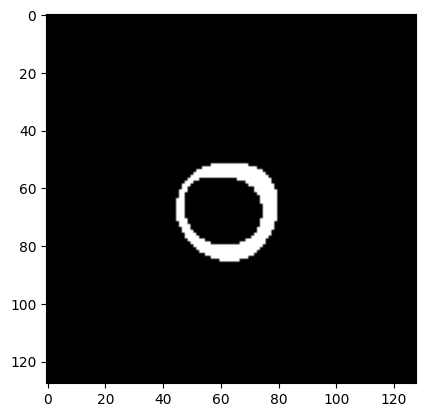

In [25]:
plt.imshow(
    processed_cine_masks[1]['mask'][...,10], cmap='gray'
)

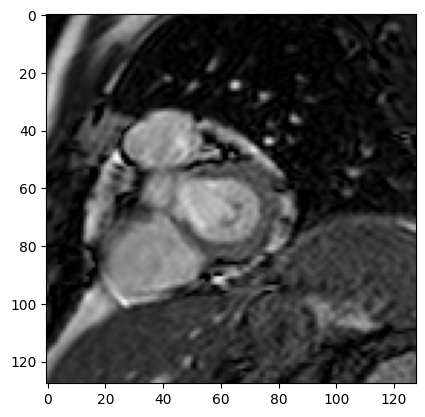

In [24]:
plt.imshow(
    processed_cine_masks[1]['mag'][...,10], cmap='gray'
)